<a href="https://colab.research.google.com/github/Andrey-Mel/works_with_text_NLP/blob/main/Predict_text_with_NN(NLP_text_author).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Импорт библиотек для работы ноутбука

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt #для вывода графиков
import os #для работы с файлами
import time
%matplotlib inline

from tensorflow.keras import utils # для работы с категориальными данными
from tensorflow.keras.models import Sequential #полносвязная модель
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D,BatchNormalization, Embedding, Flatten, Activation #Слои сети
from tensorflow.keras.preprocessing.text import Tokenizer #Метод для работы с текстом и преобразования их в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences #Метод для работы с последовательностями
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop

from sklearn.preprocessing import LabelEncoder #Метод для кодирования тестовых лейблов
from sklearn.model_selection import train_test_split #для разделения выборки на тестовую и обучающую

from google.colab import drive #для работы с google drive
from google.colab import files #для работы с файлами

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -R /content/texts #Проверяем папку texts, на наличие - если есть удалить

rm: cannot remove '/content/texts': No such file or directory


In [ ]:
#Указываем путь к базе писателей и создаем папку texts
!unzip -q '/content/drive/My Drive/Тексты писателей.zip' -d /content/texts

In [ ]:
#Создаем функцию для чтения файла на вход отправляем путь к файлу
def readText(fileName):
  f = open(fileName, 'r')#Задаем открытие файла в режиме чтения
  text = f.read()#читаем текст из файла и записываем в переменную text
  text = text.replace('\n',' ')#переносы строки переводим в пробелы
  return text

In [ ]:
className = ['О. Генри','Стругацкие','Булгаков','Саймак','Фрай','Брэдберри']#объявляем интересующие нас классы
nClasses = len(className)#считаем количество классов
print(nClasses)

6


In [ ]:
#Загружаем обучающие тексты

trainText = []
testText = []

for i in className:
  for j in os.listdir('texts/Тексты писателей/'):
    if i in j: #проверяем содержит ли файл j в названии класса i
      
      if 'Обучающая' in j: #Если в имени найденного класса есть строка "Обучающая"
        trainText.append(readText('texts/Тексты писателей/' + j))
        print(j, 'добавлен в обучающую выборку')
      if 'Тестовая' in j:
        testText.append(readText('texts/Тексты писателей/' + j))
        print(j,'добавлен в тестовую выборку')
  print()

(О. Генри) Обучающая_50 вместе.txt добавлен в обучающую выборку
(О. Генри) Тестовая_20 вместе.txt добавлен в тестовую выборку

(Стругацкие) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Стругацкие) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Булгаков) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Булгаков) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Клиффорд_Саймак) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Клиффорд_Саймак) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Макс Фрай) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Макс Фрай) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Рэй Брэдберри) Обучающая_22 вместе.txt добавлен в обучающую выборку
(Рэй Брэдберри) Тестовая_8 вместе.txt добавлен в тестовую выборку



In [ ]:
print(len(trainText))
print(len(trainText[3]))

6
1609507


**Обработка данных.Преобразования текстовых данных в числовые и векторные для обучения нейросети**

In [ ]:
curr_time = time.time()
maxWordsCount = 20000 #определяем максимальное количество слов\индексов, учитываемое при обучении

tokenizer = Tokenizer(num_words=maxWordsCount, lower=True, split=' ',oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(trainText) #Вскармливаем наши тексты, т.е. даем в обработку методу, который соберет  словарь частотности
items = list(tokenizer.word_index.items()) #Вытаскиваем индексы слов для просмотра
print('Время обработки: ', round(time.time() - curr_time, 2), 'c', sep='')

Время обработки: 2.2c


In [ ]:
print(items[:50]) #посмотрим 50 самых встречающихся слов
print("Размер словаря", len(items))

[('unknown', 1), ('и', 2), ('–', 3), ('в', 4), ('не', 5), ('я', 6), ('что', 7), ('на', 8), ('—', 9), ('с', 10), ('он', 11), ('а', 12), ('как', 13), ('то', 14), ('это', 15), ('но', 16), ('все', 17), ('у', 18), ('по', 19), ('его', 20), ('к', 21), ('так', 22), ('мне', 23), ('из', 24), ('за', 25), ('меня', 26), ('ты', 27), ('же', 28), ('сказал', 29), ('бы', 30), ('было', 31), ('\xa0–', 32), ('вы', 33), ('от', 34), ('они', 35), ('мы', 36), ('только', 37), ('еще', 38), ('\xa0—', 39), ('она', 40), ('да', 41), ('о', 42), ('когда', 43), ('уже', 44), ('был', 45), ('вот', 46), ('если', 47), ('их', 48), ('ни', 49), ('чтобы', 50)]
Размер словаря 146938


In [ ]:
#Преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText) #обучающую выборку в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText) #тестовую выборку в индексы

print('Взглянем на фрагмент обучающего текста: ')
print('В виде оригинального текста:             ', trainText[1][:87])
print('Он же в последовательности индексов:     ', trainWordIndexes[1][:20], '\n')

Взглянем на фрагмент обучающего текста: 
В виде оригинального текста:              Парень из преисподней     1     Ну и деревня! Сроду я таких деревень не видел и не знал
Он же в последовательности индексов:      [472, 24, 1, 1539, 55, 2, 12808, 7786, 6, 424, 1, 5, 257, 2, 5, 250, 57, 7, 244, 10586] 



In [ ]:
print(len(trainWordIndexes))

6


Создание обучающей и проверочной выборки

In [ ]:
#Формирование обучающей выборки по листу индексов слов

def getSetFromIndexes(wordIndexes, xLen, step):
  xSample = [] #объявляем переменную для векторов
  wordsLen = len(wordIndexes) #считаем количество слов
  index = 0 #задаем начальный индекс

  while (index + xLen <= wordsLen): #Идем по всей длине вектора индексов
    xSample.append(wordIndexes[index:index+xLen]) #откусываем векторы длины xLen
    index += step #Смещаемся вперед на step

  return xSample

In [ ]:
#Формирование обучающей и проверочной выборки
#Из двух листов индексов от двух классов
def createSetsMultiClasses(wordIndexes, xLen, step):#функция принимает последовательность индексов, размер окна, шаг от окна до окна
  #Для каждого из 6 классов
  #Создаем обучающую/проверочную выборку индексов
  nClasses = len(wordIndexes)#Задаем количество классов выборки
  classesXSamples = [] #здесь будет список размером - количество классов * количество окон в тексте * длину окна (пример 6 по 1341 * 1000)
  for wI in wordIndexes:#для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) #Добавляем в список очередной текст индексов, разбитый на количество окон * длину окна

  #Формируем один общий xSample
  xSamples = [] #Здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна (например 15777*1000)"
  ySamples = [] #Здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"

  for t in range(nClasses): #В диапазоне кол-ва классов (6)
    xT = classesXSamples[t] #Берем очередной текст вида "кол-во окон в тексте * длину окна (например 1344*1000)"
    for i in range(len(xT)): #икаждое его окно
      xSamples.append(xT[i]) #Добавляем в общий список выборки
      ySamples.append(utils.to_categorical(t, nClasses))#Добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) #Переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) #переводим в массив numpy для подачи в нейронку

  return (xSamples, ySamples) #Функция возвращает выборку и соответствующие векторы классов

Подготовка данных

In [ ]:
#Задаем параметры
xLen = 1000 #Длина отрезка текста(окно), по которой анализируем, в словах
step = 100 #Шаг разбиения исходного текста на обучающие векторы

In [ ]:
curr_time = time.time()
#Формируем обучающую и тестовую выборки
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step) #извлекаем тестовую выборку
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)
#Получили обучающий/тестовый набор достаточный для запуска Embedding, но для Bag of Words нужно xTrain и yTrain представить ввиде векторов 0 и 1
print('Время обработки: ', round(time.time() - curr_time, 2), 'c' , sep='')

(18417, 1000)
(18417, 6)
(6968, 1000)
(6968, 6)
Время обработки: 2.24c


In [ ]:
curr_time = time.time()
#Получили обучающий/тестовый набор достаточный для запуска Embedding, но для Bag of Words нужно xTrain и yTrain представить ввиде векторов 0 и 1
#Преобразовываем полученные данные выборки из последователльности индексов в матрицы 0 и 1 по принципу Bag of Words
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist())#Подаем xTrain ввиде списка, чтобы метод успешно сработал
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist())

print(xTrain01.shape)
print(xTrain01[0][0:100])#фрагмент набора слов ввиде Bag of Words
print('Время обработки: ',round(time.time() - curr_time, 2), ' c', sep='')

(18417, 20000)
[0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0.
 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1.
 0. 0. 1. 1.]
Время обработки: 10.93 c


Создаем нейросеть


Epoch 1/10
138/138 [==============================] - 2s 14ms/step - loss: 0.0508 - accuracy: 0.9841 - val_loss: 0.3913 - val_accuracy: 0.8853
Epoch 2/10
138/138 [==============================] - 2s 11ms/step - loss: 4.0227e-04 - accuracy: 1.0000 - val_loss: 0.3272 - val_accuracy: 0.8999
Epoch 3/10
138/138 [==============================] - 2s 11ms/step - loss: 1.8730e-04 - accuracy: 1.0000 - val_loss: 0.3218 - val_accuracy: 0.8995
Epoch 4/10
138/138 [==============================] - 2s 11ms/step - loss: 1.0449e-04 - accuracy: 1.0000 - val_loss: 0.3170 - val_accuracy: 0.8998
Epoch 5/10
138/138 [==============================] - 1s 11ms/step - loss: 8.2915e-05 - accuracy: 1.0000 - val_loss: 0.3163 - val_accuracy: 0.8999
Epoch 6/10
138/138 [==============================] - 1s 11ms/step - loss: 6.0884e-05 - accuracy: 1.0000 - val_loss: 0.3214 - val_accuracy: 0.8975
Epoch 7/10
138/138 [==============================] - 2s 11ms/step - loss: 4.8212e-05 - accuracy: 1.0000 - val_loss: 0.316

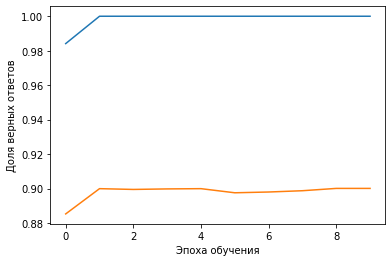

In [ ]:
#Создаем полносвязную сеть
model01 = Sequential()
#Первый слой полносвязный
model01.add(Dense(200, input_dim=maxWordsCount, activation='relu'))
#Слой регуляции Dropout
model01.add(Dropout(0.25))

#Слой пакетной нормализации
model01.add(BatchNormalization())
#Выходной полносвязный слой
model01.add(Dense(6, activation='softmax'))

model01.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

#обучаем сеть на выборке, сформированный по bag of words - xTrain01
history = model01.fit(xTrain01,
                      yTrain,
                      epochs = 10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))

plt.plot(history.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], label='Доля верных отетов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.show()

Embedding + Dense

In [ ]:
#Создаём сеть с Embedding слоем
modelE = Sequential()
modelE.add(Embedding(maxWordsCount, 200, input_length=xLen))
modelE.add(SpatialDropout1D(0.2))
modelE.add(Flatten())
modelE.add(BatchNormalization())
modelE.add(Dense(200, activation="relu"))
modelE.add(Dropout(0.2))
modelE.add(BatchNormalization())
modelE.add(Dense(6, activation='sigmoid'))

modelE.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
modelE.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 200)         10000000  
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 1000, 200)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 200000)            0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 200000)            800000    
_________________________________________________________________
dense_4 (Dense)              (None, 200)               40000200  
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 200)              

Epoch 1/10
138/138 [==============================] - 29s 212ms/step - loss: 0.9154 - accuracy: 0.7617 - val_loss: 3.4651 - val_accuracy: 0.2929
Epoch 2/10
138/138 [==============================] - 29s 208ms/step - loss: 0.2626 - accuracy: 0.9570 - val_loss: 3.2495 - val_accuracy: 0.2929
Epoch 3/10
138/138 [==============================] - 29s 207ms/step - loss: 0.0629 - accuracy: 0.9803 - val_loss: 2.3795 - val_accuracy: 0.2973
Epoch 4/10
138/138 [==============================] - 28s 205ms/step - loss: 0.0272 - accuracy: 0.9883 - val_loss: 1.3993 - val_accuracy: 0.4650
Epoch 5/10
138/138 [==============================] - 28s 206ms/step - loss: 0.0114 - accuracy: 0.9965 - val_loss: 1.2502 - val_accuracy: 0.5543
Epoch 6/10
138/138 [==============================] - 28s 205ms/step - loss: 0.0034 - accuracy: 0.9998 - val_loss: 1.0696 - val_accuracy: 0.6206
Epoch 7/10
138/138 [==============================] - 29s 207ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.9993 - val_ac

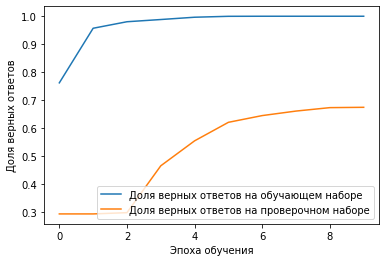

In [ ]:
#Обучаем сеть на xTrain
history = modelE.fit(xTrain, 
                    yTrain, 
                    epochs=10,
                    batch_size=128,
                    validation_data=(xTest, yTest))


plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:

#Создаем полносвязную сеть
model02 = Sequential()
#Первый слой полносвязный
model02.add(Dense(200, input_dim=maxWordsCount, activation='sigmoid'))
#Слой регуляции Dropout
model02.add(Dropout(0.4))
model02.add(BatchNormalization())
model02.add(Dense(30, input_dim=maxWordsCount, activation='linear'))
#Слой пакетной нормализации
model02.add(BatchNormalization())
#model02.add(Dropout(0.3))
#Выходной полносвязный слой
model02.add(Dense(6, activation='softmax'))

model02.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])


Epoch 1/15
49/49 [==============================] - 1s 30ms/step - loss: 0.2499 - accuracy: 0.9291 - val_loss: 0.8848 - val_accuracy: 0.8400
Epoch 2/15
49/49 [==============================] - 1s 23ms/step - loss: 0.0149 - accuracy: 1.0000 - val_loss: 0.7841 - val_accuracy: 0.9175
Epoch 3/15
49/49 [==============================] - 1s 22ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.6924 - val_accuracy: 0.9412
Epoch 4/15
49/49 [==============================] - 1s 23ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.6002 - val_accuracy: 0.9463
Epoch 5/15
49/49 [==============================] - 1s 22ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.5200 - val_accuracy: 0.9479
Epoch 6/15
49/49 [==============================] - 1s 22ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.4553 - val_accuracy: 0.9480
Epoch 7/15
49/49 [==============================] - 1s 22ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.4047 - val_accuracy: 0.9473
Epoch 8/15
49

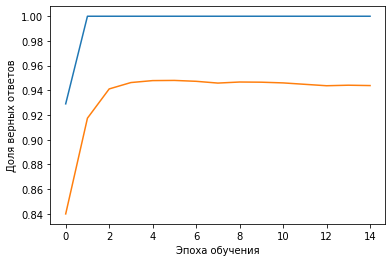

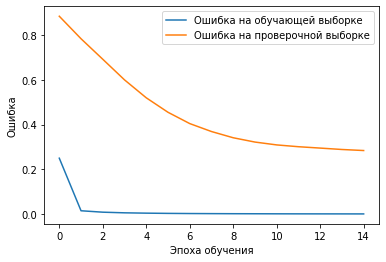

In [ ]:
#обучаем сеть на выборке, сформированный по bag of words - xTrain01
history = model02.fit(xTrain01,
                      yTrain,
                      epochs = 15,
                      batch_size=380,
                      validation_data=(xTest01, yTest))

#Визуализируем результаты
plt.plot(history.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], label='Доля верных отетов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.show()

plt.plot(history.history['loss'], label='Ошибка на обучающей выборке')
plt.plot(history.history['val_loss'], label='Ошибка на проверочной выборке')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

In [ ]:
#Распознавание выборки

def createTestMultiClasses(wordIndexes, xLen, step):
  #Для каждого из 6 классов создаем тестовую выборку
  nClasses = len(wordIndexes)
  xTest6Classes01 = []
  xTest6Classes = []

  for wI in wordIndexes:
    sample = (getSetFromIndexes(wI, xLen, step))
    xTest6Classes.append(sample)
    xTest6Classes01.append(tokenizer.sequences_to_matrix(sample))

  xTest6Classes01 = np.array(xTest6Classes01)
  xTest6Classes = np.array(xTest6Classes)

  return xTest6Classes01, xTest6Classes

#Распознаем тестовую выборку и выводим результаты
def recognizeMultiClass(model, xTest, modelName):
  print("НЕЙРОНКА: ", modelName)
  print()
  
  totalSumRec = 0 # Сумма всех правильных ответов
  
  #Проходим по всем классам
  for i in range(nClasses):
    #Получаем результаты распознавания класса по блокам слов длины xLen
    currPred = model.predict(xTest[i])
    #Определяем номер распознанного класса для каждохо блока слов длины xLen
    currOut = np.argmax(currPred, axis=1)

    evVal = []
    for j in range(nClasses):
      evVal.append(len(currOut[currOut==j])/len(xTest[i]))

    totalSumRec += len(currOut[currOut==i])
    recognizedClass = np.argmax(evVal) #Определяем, какой класс в итоге за какой был распознан
    
    #Выводим результаты распознавания по текущему классу
    isRecognized = "Это НЕПРАВИЛЬНЫЙ ответ!"
    if (recognizedClass == i):
      isRecognized = "Это ПРАВИЛЬНЫЙ ответ!"
    str1 = 'Класс: ' + className[i] + " " * (11 - len(className[i])) + str(int(100*evVal[i])) + "% сеть отнесла к классу " + className[recognizedClass]
    print(str1, " " * (55-len(str1)), isRecognized, sep='')
  
  #Выводим средний процент распознавания по всем классам вместе
  print()
  sumCount = 0
  for i in range(nClasses):
    sumCount += len(xTest[i])
  print("Средний процент распознавания ", int(100*totalSumRec/sumCount), "%", sep='')

  print()
  
  return totalSumRec/sumCount
 



In [ ]:
   xTest6Classes01, x2 = createTestMultiClasses(testWordIndexes, xLen, step) #Преобразование тестовой выборки

In [ ]:
#Проверяем точность нейронки обученной на bag of words
pred = recognizeMultiClass(model02, xTest6Classes01, "Тексты  + Dense")

НЕЙРОНКА:  Тексты  + Dense

Класс: О. Генри   99% сеть отнесла к классу О. Генри   Это ПРАВИЛЬНЫЙ ответ!
Класс: Стругацкие 91% сеть отнесла к классу Стругацкие Это ПРАВИЛЬНЫЙ ответ!
Класс: Булгаков   90% сеть отнесла к классу Булгаков   Это ПРАВИЛЬНЫЙ ответ!
Класс: Саймак     90% сеть отнесла к классу Саймак     Это ПРАВИЛЬНЫЙ ответ!
Класс: Фрай       94% сеть отнесла к классу Фрай       Это ПРАВИЛЬНЫЙ ответ!
Класс: Брэдберри  99% сеть отнесла к классу Брэдберри  Это ПРАВИЛЬНЫЙ ответ!

Средний процент распознавания 94%

